# 포트폴리오 만들기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock

In [3]:
#삼성전자, SK하이닉스,  삼성바이오로직스, NAVER, 현대차
stocks = ['005930', '000660', '207940', '035420','005380']

In [4]:
df = pd.DataFrame()
for s in stocks: 
    df[s] = stock.get_market_ohlcv_by_date("20170101", "20211231", s)['종가'] #약 5년간데이터
df.columns = ['삼성전자', 'SK하이닉스',  '삼성바이오로직스', 'NAVER','현대차']

In [5]:
df

,삼성전자,SK하이닉스,삼성바이오로직스,NAVER,현대차
날짜,,,,,
2017-01-02,36100,45800,154668,155620,150000
2017-01-03,36480,47250,156151,153617,153000
2017-01-04,36160,46500,152692,162230,154000
2017-01-05,35560,46950,155657,158424,153500
2017-01-06,36200,48000,155657,160026,151000
...,...,...,...,...,...
2021-12-24,80500,128000,874642,384000,215500
2021-12-27,80200,126000,875631,380500,213500
2021-12-28,80300,127500,880572,384500,214000


In [6]:
daily_ret = np.log(df/df.shift(1))        #일간수익률
annual_ret = daily_ret.mean() * 252 #연간수익률 #252는 주식시장이 여는 총 252일을 뜻한다.
daily_cov = daily_ret.cov()         #일간변동률의 공분산
annual_cov = daily_cov * 252        #연간공분산

In [7]:
annual_ret

삼성전자        0.158886
SK하이닉스      0.215660
삼성바이오로직스    0.359668
NAVER       0.182392
현대차         0.068069
dtype: float64

## 몬테카를로 시뮬레이션

In [8]:
port_ret = []
port_risk = []
port_weights = []
sharpe_ratio = []

for _ in range(20000): #총 2만회 반복
    weights = np.random.random(len(stocks)) #각 주식당 0~1사이의 가중치(W)를 랜덤하게 배정
    weights /= np.sum(weights) 
    
    if _ < 5 :
        print(weights)
    
    #log(1.02)*5 연 2%정기예금을 무위험수익으로 생각 : 0.043
    
    returns = np.dot(weights, annual_ret)-0.043 #개별 주식의 연간수익률과 가중치를 점곱 == 수익률
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) #리스크 == wCw 형태
    
    sharpe = returns / risk #샤프ratio
    
    port_ret.append(returns) #각 가중치당 포트폴리오의 리턴
    port_risk.append(risk)   #각 가중치당 포트폴리오의 리스크
    port_weights.append(weights)
    sharpe_ratio.append(returns/risk) #각 가중치당 포트폴리오의 샤프지수


[0.32685126 0.06778197 0.01858986 0.12225089 0.46452601]
[0.02990582 0.4055645  0.42886362 0.05227971 0.08338636]
[0.46585324 0.13186356 0.3007545  0.01258846 0.08894023]
[0.2292989  0.19671918 0.2063816  0.19599907 0.17160126]
[0.31838966 0.15558456 0.08297195 0.14912576 0.29392807]


In [9]:
portfolio = {'Returns': port_ret, 'Risk': port_risk, 'Sharpe': sharpe_ratio}
for i, s in enumerate(stocks):
    portfolio[s] = [weight[i] for weight in port_weights]
df = pd.DataFrame(portfolio)
df.columns = ['Returns','Risk', 'Sharpe','삼성전자', 'SK하이닉스',  '삼성바이오로직스', 'NAVER','현대차']
df.head()

,Returns,Risk,Sharpe,삼성전자,SK하이닉스,삼성바이오로직스,NAVER,현대차
0,0.084153,0.235386,0.357511,0.326851,0.067782,0.018590,0.122251,0.464526
1,0.218676,0.275635,0.793352,0.029906,0.405565,0.428864,0.052280,0.083386
2,0.175977,0.237945,0.739572,0.465853,0.131864,0.300755,0.012588,0.088940
3,0.157515,0.221255,0.711915,0.229299,0.196719,0.206382,0.195999,0.171601
4,0.118190,0.220234,0.536657,0.318390,0.155585,0.082972,0.149126,0.293928


## Efficient Frontier

c:\users\82108\.conda\envs\kaggle\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


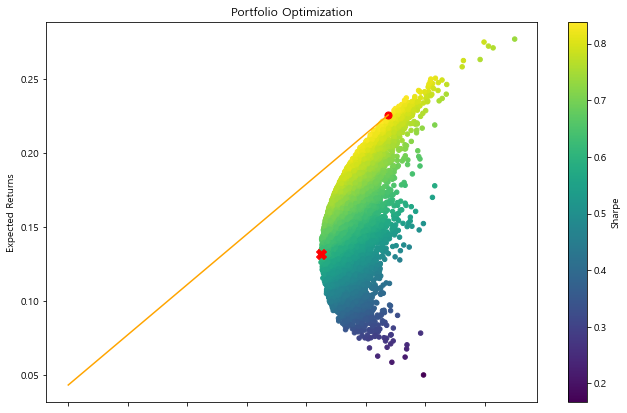

In [10]:

max_sharpe = df.loc[df['Sharpe'] == df['Sharpe'].max()]
min_risk = df.loc[df['Risk'] == df['Risk'].min()]

# plot

df.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap = 'viridis', figsize = (11,7))
plt.scatter(x = max_sharpe['Risk'], y = max_sharpe['Returns'], c = 'r',  s=50)
plt.scatter(x = min_risk['Risk'], y = min_risk['Returns'], c = 'r', marker = 'X', s=100)

plt.plot([0, max_sharpe['Risk']], [0.043, max_sharpe['Returns']],color="orange")

plt.title('Portfolio Optimization')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.show()

In [11]:
max_sharpe

,Returns,Risk,Sharpe,삼성전자,SK하이닉스,삼성바이오로직스,NAVER,현대차
15837,0.225478,0.268915,0.838471,0.049123,0.255936,0.445903,0.246221,0.002817


## 주식 종목의 수가 늘어난다면?

In [12]:
df = pd.DataFrame()
for s in stocks: 
    df[s] = stock.get_market_ohlcv_by_date("20170101", "20211231", s)['종가'] #약 5년간데이터
df.columns = ['삼성전자', 'SK하이닉스',  '삼성바이오로직스', 'NAVER','현대차']

In [13]:
daily_ret = np.log(df/df.shift(1))        #일간수익률
annual_ret = daily_ret.mean() * 252 #연간수익률 #252는 주식시장이 여는 총 252일을 뜻한다.

df = daily_ret

In [14]:
df = df.dropna()

In [15]:
# 주성분(pca)방법을 이용한다.

from sklearn.decomposition import PCA

def fit_pca(returns, num_factor_exposures, svd_solver):
    
    pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)
    
    return pca

num_factor_exposures=3
svd_solver='full'

pca = fit_pca(df, num_factor_exposures, svd_solver)

3개의 Risk Factor에 의해 설명되는 데이터의 분산 : 81.82773964287495%


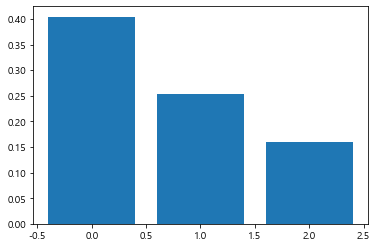

In [16]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_);
print(f'{num_factor_exposures}개의 Risk Factor에 의해 설명되는 데이터의 분산 : {sum(pca.explained_variance_ratio_)*100}%')

In [17]:
factor_L = pd.DataFrame(pca.components_.T, index=df.columns, columns=np.arange(num_factor_exposures))
factor_L

,0,1,2
삼성전자,0.350974,0.278114,-0.191055
SK하이닉스,0.494274,0.477693,-0.543180
삼성바이오로직스,0.620686,-0.776530,-0.087531
NAVER,0.341238,0.167772,0.381912
현대차,0.361685,0.251626,0.717589


In [18]:
factor_F = pd.DataFrame(pca.transform(df), index=df.index, columns=np.arange(num_factor_exposures))
factor_F

,0,1,2
날짜,,,
2017-01-03,0.025871,0.013535,-0.010263
2017-01-04,-0.005808,0.018428,0.038084
2017-01-05,-0.000327,-0.019454,-0.014878
2017-01-06,0.012812,0.013417,-0.023123
2017-01-09,0.001801,0.033092,-0.032708
...,...,...,...
2021-12-24,0.011469,0.024227,0.025758
2021-12-27,-0.016765,-0.012986,-0.000779
2021-12-28,0.012319,0.004308,-0.001246


In [19]:
common_returns = pd.DataFrame(np.dot(factor_F, factor_L.T), index=df.index, columns=df.columns)
specific_returns = df - common_returns

# diagonal을 취하는 이유 -> 행렬 계산을 위해
idiosyncratic_var_matrix = pd.DataFrame(np.diag(np.var(specific_returns)), index=df.columns, columns=df.columns)
idiosyncratic_var_matrix

,삼성전자,SK하이닉스,삼성바이오로직스,NAVER,현대차
삼성전자,0.000083,0.000000,0.000000,0.000000,0.000000
SK하이닉스,0.000000,0.000027,0.000000,0.000000,0.000000
삼성바이오로직스,0.000000,0.000000,0.000001,0.000000,0.000000
NAVER,0.000000,0.000000,0.000000,0.000242,0.000000
현대차,0.000000,0.000000,0.000000,0.000000,0.000097


In [20]:
factor_covariance_matrix = np.cov(factor_F.T)
factor_covariance_matrix

array([[ 1.00286582e-03,  6.35499757e-19, -3.42491249e-19],
       [ 6.35499757e-19,  6.29734650e-04,  1.14870646e-19],
       [-3.42491249e-19,  1.14870646e-19,  3.96910848e-04]])

In [22]:
L = factor_L
F = factor_covariance_matrix
S = idiosyncratic_var_matrix

portfolio_covariance = L.dot(F).dot(L.T) + S
portfolio_covariance

,삼성전자,SK하이닉스,삼성바이오로직스,NAVER,현대차
삼성전자,0.000269,0.000299,0.000089,0.000121,0.000117
SK하이닉스,0.000299,0.000532,0.000093,0.000137,0.000100
삼성바이오로직스,0.000089,0.000093,0.000770,0.000117,0.000077
NAVER,0.000121,0.000137,0.000117,0.000435,0.000259
현대차,0.000117,0.000100,0.000077,0.000259,0.000473


In [23]:
daily_cov = portfolio_covariance        #일간변동률의 공분산
annual_cov = daily_cov * 252        #연간공분산

In [42]:
port_ret = []
port_risk = []
port_weights = []
sharpe_ratio = []

for _ in range(20000): #총 2만회 반복
    weights = np.random.random(len(stocks)) #각 주식당 0~1사이의 가중치(W)를 랜덤하게 배정
    weights /= np.sum(weights) 
    
    if _ < 5 :
        print(weights)
    
    #log(1.02)*5 연 2%정기예금을 무위험수익으로 생각 : 0.043
    
    returns = np.dot(weights, annual_ret)-0.043 #개별 주식의 연간수익률과 가중치를 점곱 == 수익률
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) #리스크 == wCw 형태
    
    sharpe = returns / risk #샤프ratio
    
    port_ret.append(returns) #각 가중치당 포트폴리오의 리턴
    port_risk.append(risk)   #각 가중치당 포트폴리오의 리스크
    port_weights.append(weights)
    sharpe_ratio.append(returns/risk) #각 가중치당 포트폴리오의 샤프지수

    


[0.12428409 0.19227872 0.08001587 0.46573705 0.13768427]
[0.06451824 0.39377115 0.06821192 0.08383399 0.3896647 ]
[0.22022884 0.20719795 0.26763974 0.09980642 0.20512705]
[0.36858794 0.1409314  0.08678252 0.23725125 0.16644688]
[0.50019129 0.22063696 0.08766132 0.17195217 0.01955827]


In [43]:
portfolio = {'Returns': port_ret, 'Risk': port_risk, 'Sharpe': sharpe_ratio}
for i, s in enumerate(stocks):
    portfolio[s] = [weight[i] for weight in port_weights]
df = pd.DataFrame(portfolio)
df.columns = ['Returns','Risk', 'Sharpe','삼성전자', 'SK하이닉스',  '삼성바이오로직스', 'NAVER','현대차']
df.head()

,Returns,Risk,Sharpe,삼성전자,SK하이닉스,삼성바이오로직스,NAVER,현대차
0,0.141312,0.247200,0.571649,0.124284,0.192279,0.080016,0.465737,0.137684
1,0.118520,0.252223,0.469902,0.064518,0.393771,0.068212,0.083834,0.389665
2,0.165104,0.234826,0.703089,0.220229,0.207198,0.267640,0.099806,0.205127
3,0.131772,0.228071,0.577768,0.368588,0.140931,0.086783,0.237251,0.166447
4,0.148279,0.240490,0.616571,0.500191,0.220637,0.087661,0.171952,0.019558


c:\users\82108\.conda\envs\kaggle\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


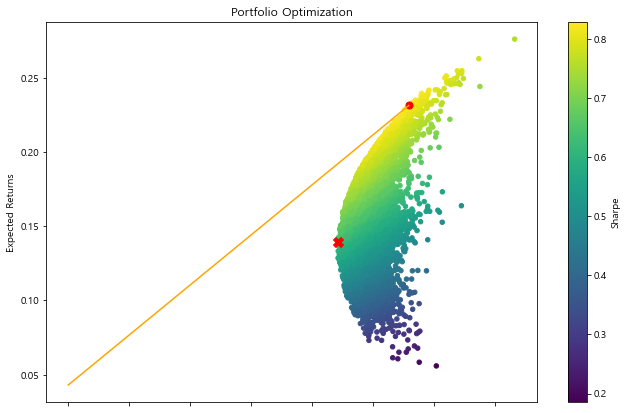

In [44]:
max_sharpe = df.loc[df['Sharpe'] == df['Sharpe'].max()]
min_risk = df.loc[df['Risk'] == df['Risk'].min()]

# plot

df.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap = 'viridis', figsize = (11,7))
plt.scatter(x = max_sharpe['Risk'], y = max_sharpe['Returns'], c = 'r',  s=50)
plt.scatter(x = min_risk['Risk'], y = min_risk['Returns'], c = 'r', marker = 'X', s=100)

plt.plot([0, max_sharpe['Risk']], [0.043,  max_sharpe['Returns']],color="orange")

plt.title('Portfolio Optimization')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.show()

In [45]:
max_sharpe

,Returns,Risk,Sharpe,삼성전자,SK하이닉스,삼성바이오로직스,NAVER,현대차
13632,0.231441,0.279133,0.829141,0.054505,0.269577,0.478999,0.192077,0.004842
